In [1]:
# import brewer2mpl
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import *
from scipy import *
import scipy.spatial.distance as distance
import scipy.cluster.hierarchy as sch
import numpy as np
# from mnist import MNIST
import matplotlib.pyplot as plt

In [2]:
## Load in metada tafile
# 1. read metadata;
# smp_2_size, smp_2_donor
smp_2_size = {}
smp_2_donor = {}
smp_2_species = {}
smp_2_align = {}
species_2_phylum = {}
smp_2_phylum={}
Filtered_Species_smplist={}
Filtered_Species_donorlist={}
Filtered_Species_sizelist={}
with open('../Intermediary-files/filtered_samples.csv') as file:
    for line in file:
        if 'GenomeSize' not in line:
            smp, sp, size, donor, align, phylum = line.strip().split(',')[0],line.strip().split(',')[1], int(line.strip().split(',')[2]), line.strip().split(',')[3],line.strip().split(',')[4],line.strip().split(',')[7]
            smp_2_size[smp] = size
            smp_2_donor[smp] = donor
            smp_2_species[smp]=sp
            smp_2_align[smp]=align
            smp_2_phylum[smp]=phylum
            species_2_phylum[sp]=phylum
            if sp not in Filtered_Species_smplist:
                Filtered_Species_smplist[sp]=[]
                Filtered_Species_donorlist[sp]={}
                Filtered_Species_sizelist[sp]=[]
            Filtered_Species_smplist[sp].append(smp)
            Filtered_Species_sizelist[sp].append(size)
            if donor not in Filtered_Species_donorlist[sp]:
                Filtered_Species_donorlist[sp][donor]=[]
            Filtered_Species_donorlist[sp][donor].append(smp)

In [3]:
## 2. Read in the pangenome files
DS_species_gene_smp = {}
DS_species_smp_gene = {}
mk=0
with open('../Intermediary-files/nn_clusterResffn_cluster.tsv') as g:
    for line in g:
        tmp = line.strip().split('\t')
        geneid = tmp[0]
        smp = tmp[1].split('_contig')[0]
        if smp in smp_2_species:
            species = smp_2_species[smp]
            mk = mk+1
            if mk%10000000 ==1:
                print(mk)
            # Initialize dictionaries if they don't exist
            DS_species_gene_smp.setdefault(species, {}).setdefault(geneid, {})[smp] = 1
            DS_species_smp_gene.setdefault(species, {}).setdefault(smp, {})[geneid] = 1

# Optional: Print the number of species in DS_species_gene_smp
print(len(DS_species_gene_smp))


1
10000001
20000001
30000001
40000001
50000001
60000001
70000001
80000001
268


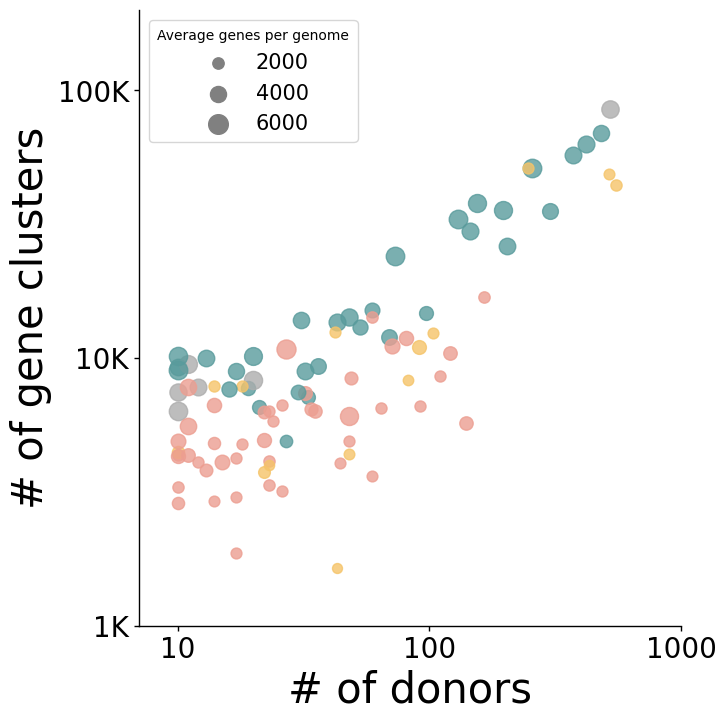

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define phylum colors
phyla_2_color = {
    'Bacteroidetes': [89/256, 156/256, 157/256],
    'Proteobacteria': [174/256, 174/256, 174/256],
    'Actinobacteria': [246/256, 197/256, 105/256],
    'Firmicutes': [237/256, 159/256, 146/256]
}

# Set figure size
fig, ax = plt.subplots(figsize=(7, 8))

# Initialize dictionary for pangenome size by species
Pangenomesize_by_species = {}

# Iterate over species in Filtered_Species_donorlist
for sp in Filtered_Species_donorlist:
    if len(Filtered_Species_donorlist[sp]) >= 10:
        genenumlist = [len(DS_species_smp_gene[sp][smp]) for smp in DS_species_smp_gene[sp]]
        phylum = species_2_phylum[sp]
        c = phyla_2_color[phylum]
        pangenomesize = sum(1 for gene in DS_species_gene_smp[sp] if len(DS_species_gene_smp[sp][gene]) > 1)
        Pangenomesize_by_species[sp] = pangenomesize
        averagegenomesize = np.average(genenumlist)
        donornumber = len(Filtered_Species_donorlist[sp])
        plt.scatter(np.log10(donornumber), np.log10(pangenomesize), color=c, alpha=0.8, s=averagegenomesize/30)

# Create custom legend handles with different marker sizes
legend_handles = [plt.scatter([], [], s=size/30, label=f'{size}', color='gray') for size in [2000, 4000, 6000]]

# Add legend
plt.legend(handles=legend_handles, loc='upper left', title='Average genes per genome', fontsize=15)

# Set axes limits and customize appearance
plt.xlim([np.log10(7), 3])
plt.ylim([np.log10(1000), np.log10(200000)])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.xaxis.set_tick_params(width=1, color='black')
ax.yaxis.set_tick_params(width=1, color='black')
plt.xlabel("# of donors", fontsize=30)
plt.ylabel("# of gene clusters", fontsize=30)
plt.xticks([1, 2, 3], [10, 100, 1000], fontsize=20)
plt.yticks([3, 4, 5], ['1K', '10K', '100K'], fontsize=20)
fig.savefig('figures/FigureS1C.pdf', dpi=300, bbox_inches='tight')


In [6]:
#  core vs accessory plot
import random

Pangenome_curve_by_species_donor={}
Coregenome_curve_by_species_donor={}
abundant_list = ['Bifidobacterium_adolescentis','Escherichia_coli','Bifidobacterium_longum','Bacteroides_uniformis','Parabacteroides_distasonis']
for sp in abundant_list:
    Pangenome_curve_by_species_donor[sp]={}
    Coregenome_curve_by_species_donor[sp]={}
    corecutoff = 0.95
    donor_keys = list(Filtered_Species_donorlist[sp].keys())
    for i in range(10,len(Filtered_Species_donorlist[sp]),50):
        Pangenome_curve_by_species_donor[sp][i]=[]
        Coregenome_curve_by_species_donor[sp][i]=[]
        for repeat in range(5):
            donorlist = random.sample(donor_keys, i)
            smplist = []
            for donor in donorlist:
                smplist.append(random.sample(Filtered_Species_donorlist[sp][donor], 1)[0])
            print(i,len(smplist))
            genelist={}
            for smp in smplist:
                for gene in DS_species_smp_gene[sp][smp]:
                    if gene not in genelist:
                        genelist[gene]=0
                    genelist[gene]+=1
            totalgene = 0
            coregene=0
            for gene in genelist:
                if genelist[gene]>i*corecutoff:
                    coregene+=1
                if genelist[gene]>1:
                    totalgene+=1
            Pangenome_curve_by_species_donor[sp][i].append(totalgene)
            Coregenome_curve_by_species_donor[sp][i].append(coregene)
            print(i)

10 10
10
10 10
10
10 10
10
10 10
10
10 10
10
60 60
60
60 60
60
60 60
60
60 60
60
60 60
60
110 110
110
110 110
110
110 110
110
110 110
110
110 110
110
160 160
160
160 160
160
160 160
160
160 160
160
160 160
160
210 210
210
210 210
210
210 210
210
210 210
210
210 210
210
260 260
260
260 260
260
260 260
260
260 260
260
260 260
260
310 310
310
310 310
310
310 310
310
310 310
310
310 310
310
360 360
360
360 360
360
360 360
360
360 360
360
360 360
360
410 410
410
410 410
410
410 410
410
410 410
410
410 410
410
460 460
460
460 460
460
460 460
460
460 460
460
460 460
460
510 510
510
510 510
510
510 510
510
510 510
510
510 510
510
10 10
10
10 10
10
10 10
10
10 10
10
10 10
10
60 60
60
60 60
60
60 60
60
60 60
60
60 60
60
110 110
110
110 110
110
110 110
110
110 110
110
110 110
110
160 160
160
160 160
160
160 160
160
160 160
160
160 160
160
210 210
210
210 210
210
210 210
210
210 210
210
210 210
210
260 260
260
260 260
260
260 260
260
260 260
260
260 260
260
310 310
310
310 310
310
310 310
310
310 

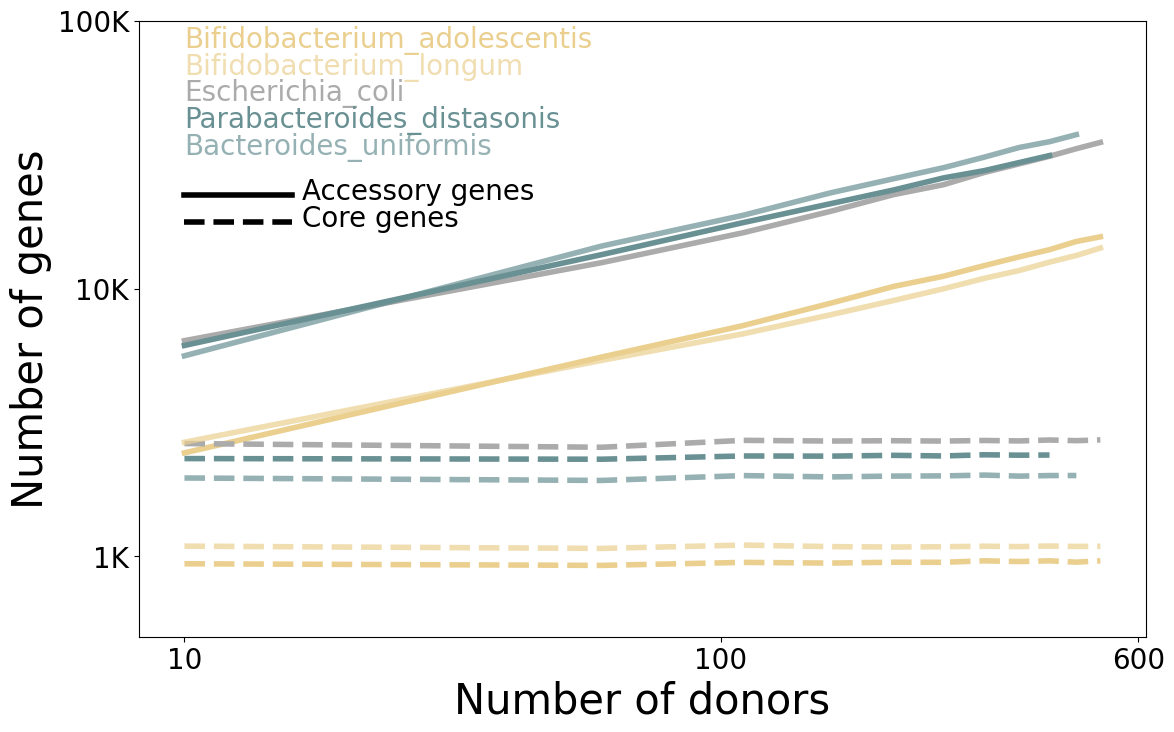

In [7]:
## Reproduce Figure 1D
fig, ax = plt.subplots(figsize=(13,8))  # Set the width and height in inches
colors={}
colors['Bifidobacterium_adolescentis'] = '#EACF8F'
colors['Bifidobacterium_longum'] = '#EACF8F'
colors['Escherichia_coli'] = '#ABABAB'
colors['Parabacteroides_distasonis'] = '#699093'
colors['Bacteroides_uniformis'] = '#699093'

spalpha={}
spalpha['Bifidobacterium_adolescentis'] = 1
spalpha['Bifidobacterium_longum'] = 0.7
spalpha['Escherichia_coli'] = 1
spalpha['Parabacteroides_distasonis'] = 1
spalpha['Bacteroides_uniformis'] = 0.7


for sp in abundant_list:
    xs=[]
    ys=[]
    for x in Pangenome_curve_by_species_donor[sp]:
        y = np.mean(Pangenome_curve_by_species_donor[sp][x])
        xs.append(np.log10(x))
        ys.append(np.log10(y))
    plt.plot(xs,ys,color=colors[sp],linewidth=4,alpha=spalpha[sp])
    xs=[]
    ys=[]
    for x in Coregenome_curve_by_species_donor[sp]:
        y = np.mean(Coregenome_curve_by_species_donor[sp][x])
        xs.append(np.log10(x))
        ys.append(np.log10(y))
    plt.plot(xs,ys,'--',color=colors[sp],linewidth=4,alpha=spalpha[sp])
# plt.xscale('log')
# plt.yscale('log')


# Remove ticks on the top and right sides
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Set the x-axis and y-axis tick color to black
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
# Set the x-axis and y-axis line color to black
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# Change the font size of x-axis and y-axis labels
plt.xlabel("Number of donors", fontsize=30)
plt.ylabel("Number of genes", fontsize=30)

# Customize x-axis tick labels
x_ticks_positions = [1, 2, np.log10(600)]  # Positions where custom labels will be placed
cus_x_ticks_positions = [10,100,600]
plt.xticks(x_ticks_positions, cus_x_ticks_positions, fontsize=20)

# Customize x-axis tick labels
x_ticks_positions = [3,4,5]  # Positions where custom labels will be placed
cus_x_ticks_positions=["1K","10K","100K"]
plt.yticks(x_ticks_positions, cus_x_ticks_positions, fontsize=20)
ylim(2.7,5)
ypos=4.9
for sp in colors:
    plt.text(1,ypos,sp,color=colors[sp],fontsize=20,alpha=spalpha[sp])
    ypos=ypos-0.1
ypos=ypos-0.05
plt.plot([1,1.2],[ypos,ypos],linewidth=4,color='k')
plt.text(1.22,ypos-0.02,'Accessory genes',color='k',fontsize=20)
ypos=ypos-0.1
plt.plot([1,1.2],[ypos,ypos],'--',linewidth=4,color='k')
plt.text(1.22,ypos-0.02,'Core genes',color='k',fontsize=20)


# Show the histogram
fig.savefig('figures/Figure1D.pdf', dpi=600, bbox_inches='tight')
plt.show()